## Working with Data

In [50]:
from collections import Counter, defaultdict
import functools
import random
import matplotlib.pyplot as plt
import math
import csv
import dateutil.parser
import datetime

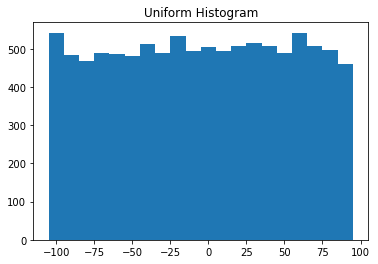

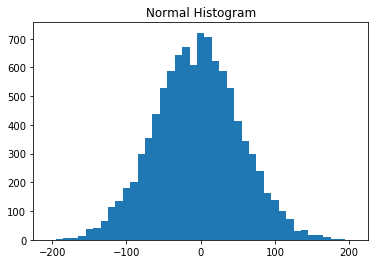

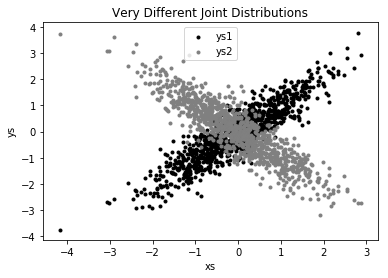

In [51]:
def bucketize(point, bucket_size):
    '''floor the point to the next lower multiple of bucket_size'''
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    '''buckets the points and count how many in each bucket'''
    return Counter(bucketize(point, bucket_size)
                  for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(list(histogram.keys()), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu)/ math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    '''find approximate inverse using binary search'''
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)    
    low_z = -10.0
    hi_z  = 10.0
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2
        mid_p = normal_cdf(mid_z)
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z = mid_z
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z = mid_z
        else:
            break
            
    return mid_z    

def random_normal():
    '''returns a random draw from a standard normal distribution'''
    return inverse_normal_cdf(random.random())



random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0 and standard deviation of 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

plot_histogram(uniform, 10, "Uniform Histogram")
plot_histogram(normal, 10, "Normal Histogram")

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='grey', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

### Many Dimension

0.9010493686379609
-0.8920981526880033


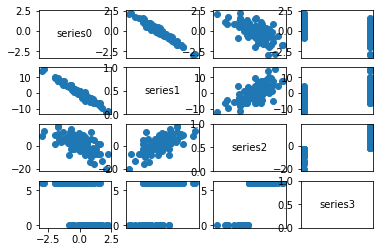

In [52]:
def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    
    return num_rows, num_cols

def dot(v, w):
    '''v_1 * w_1 + ... + v_n * w_n'''
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    '''v_1 * v_1 + ... + v_n * v_n'''
    return dot(v, v)


def mean(x):    
    result = sum(x)/len(x)    
    return result

def de_mean(x):
    '''translate x by subtracting its mean (so the result has mean 0)'''
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y))/(n-1)

def variance(x):
    '''assume x has at least two elements'''
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations)/(n-1)

def standard_dev(v):
    return math.sqrt(variance(v))

def correlation(x, y):
    stdev_x = standard_dev(x)
    stdev_y = standard_dev(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y

def get_column(A, j):
    return [A_i[j] for A_i in A]    

    
def make_matrix(num_rows, num_cols, entry_fn):
    '''returns a num_rows x num_cols matrix
       whose (i, j)th entry is entry_fn(i, j)'''
    
    return [[entry_fn(i, j) 
             for j in range(num_cols)]
           for i in range(num_rows)]

def correlation_matrix(data):
    '''return the num_columns x num_columns matrix whose (i,j)th entry
       is the correlation between column i and j of data'''
    
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)


def make_scatterplot_matrix():

    # first, generate some random data

    num_points = 100
    
    def random_row():
        row = [None, None, None, None]
        row[0] = random_normal()
        row[1] = -5 * row[0] + random_normal()
        row[2] = row[0] + row[1] + 5 * random_normal()
        row[3] = 6 if row[2] > -2 else 0
        return row
    random.seed(0)
    data = [random_row()
            for _ in range(num_points)]
     
    # plot
    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if  i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
            else:
                ax[i][j].annotate('series' + str(i), (0.5, 0.5),
                                  xycoords='axes fraction',
                                  ha='center', va='center')
            # then hide axis label except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].xaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())

    plt.show()





if __name__ == "__main__":
    
    print(correlation(xs, ys1))
    print(correlation(xs, ys2))
    
    make_scatterplot_matrix()
    
    

   

In [53]:
def parse_row(input_row, parsers):
    """give a list of parser (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    
    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parser to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)
        
        
def try_or_none(f):
    """wraps f to return None if f raise an exception
     assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none


def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]


def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name)
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return {field_name : try_parse_field(field_name, value, parser_dict)
            for field_name, value in input_dict.iteritems()}
    
    
if __name__ == "__main__":
    
    data = []

    with open("comma_delimited_stock_price.csv", "r") as f:
        reader = csv.reader(f)
        for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
            data.append(line)

    for row in data:
        if any(x is None for x in row):
            print(row)
        



### Manipulating Data

In [54]:
def picker(field_name):
    """return a function that picks a field out of a dict"""
    return lambda row: row[field_name]
    
def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def combine_pct_change(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return functools.reduce(combine_pct_change, pluck('change', changes))
 
def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    else:
        return {key: value_transform(rows)
                for key, rows in grouped.items()}

#data = [
#        {'closing_price' : 102.06,
#         'date' : datetime.datetime(2017, 8, 29, 0),
#         'symbol' : 'AAPL'},
#        {'closing_price' : 102.06,
#         'date' : datetime.datetime(2017, 7, 22, 0),
#         'symbol' : 'FB'},
#        {'closing_price' : 105.06,
#         'date' : datetime.datetime(2017, 7, 22, 0),
#         'symbol' : 'MSFT'}      
#        ]

data = [
    {'closing_price':102.06,
    'date':datetime.datetime(2014,8,29,0,0),
    'symbol':'AAPL'},
    {'closing_price':104.04,
    'date':datetime.datetime(2014,8,30,0,0),
    'symbol':'AAPL'},
    {'closing_price':41.68,
    'date':datetime.datetime(2014,8,29,0,0),
    'symbol':'MSFT'},
    {'closing_price':42.44,
    'date':datetime.datetime(2014,8,30,0,0),
    'symbol':'MSFT'},
    {'closing_price':64.5,
    'date':datetime.datetime(2014,8,29,0,0),
    'symbol':'FB'},
    {'closing_price':66.66,
    'date':datetime.datetime(2014,8,30,0,0),
    'symbol':'FB'}
]

max_apple_price  = max(row['closing_price'] 
                       for row in data
                       if row['symbol'] == 'AAPL')
print('maximum closing price for apple stock %.2f\n' %max_apple_price)

# group rows by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row['symbol']].append(row)
    
#print('symbol row: {}\n'.format(by_symbol))

# using list comprehension to find the max for each symbol
max_price_by_symbol = {symbol: max(row['closing_price']
                                   for row in grouped_rows)
                                  for symbol, grouped_rows in by_symbol.items()}
print('max price by symbol: {}'.format(max_price_by_symbol))

# max price by symbol using functions
max_price_by_symbol_v2 = group_by(picker('symbol'),
                                  data,
                                  lambda rows: max(pluck('closing_price', rows)))
print('max price by symbol v2: {}'.format(max_price_by_symbol_v2))




maximum closing price for apple stock 104.04

max price by symbol: {'MSFT': 42.44, 'FB': 66.66, 'AAPL': 104.04}
max price by symbol v2: {'MSFT': 42.44, 'FB': 66.66, 'AAPL': 104.04}


In [55]:
def percent_price_change(yesterday, today):
    return today["closing_price"]/yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    #sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    
    # zip with an offset to get pairs of consecutive days
    return [ { "symbol" : today["symbol"],
             "date": today["date"],
             "change": percent_price_change(yesterday, today)}
            for yesterday,today in zip(ordered, ordered[1:])]

#key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"),data, day_over_day_changes)

print ("change_by_symbol ", changes_by_symbol)
#collect all "change" dicts into 
all_changes = [change
              for changes in changes_by_symbol.values()
              for change in changes]    


#def combine_pctchanges
#def overall
print("------------------------------------------------------")
#max(all_changes, key =picker("change"))
print("max(all_changes, key =picker(change)) ", max(all_changes, key =picker("change")) )
print("------------------------------------------------------")
print("min(all_changes, key =picker(change)) ", min(all_changes, key =picker("change")) )
print("------------------------------------------------------")


overall_change_by_month = group_by(lambda row: row['date'].month,
                                   all_changes,
                                   overall_change)
print('overall change by month: ',overall_change_by_month)

change_by_symbol  {'MSFT': [{'date': datetime.datetime(2014, 8, 30, 0, 0), 'symbol': 'MSFT', 'change': 0.018234165067178454}], 'FB': [{'date': datetime.datetime(2014, 8, 30, 0, 0), 'symbol': 'FB', 'change': 0.033488372093023244}], 'AAPL': [{'date': datetime.datetime(2014, 8, 30, 0, 0), 'symbol': 'AAPL', 'change': 0.01940035273368612}]}
------------------------------------------------------
max(all_changes, key =picker(change))  {'date': datetime.datetime(2014, 8, 30, 0, 0), 'symbol': 'FB', 'change': 0.033488372093023244}
------------------------------------------------------
min(all_changes, key =picker(change))  {'date': datetime.datetime(2014, 8, 30, 0, 0), 'symbol': 'MSFT', 'change': 0.018234165067178454}
------------------------------------------------------
overall change by month:  {8: 0.07274880434963182}


In [56]:
def scale(data_matrix):
    
    """return the means and standard deviation of each column"""
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix, j))
             for j in range(num_cols)]
    stdevs = [standard_dev(get_column(data_matrix,j))
              for j in range(num_cols)]
    
    return means, stdevs


def rescale(data_matrix):
    """rescales the input data so that each column has mean 0 and standard deviation 1
    leaves alone columns with no deviation"""
    
    means, stdevs = scale(data_matrix)
    
    def rescaled(i,j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j])/ stdevs[j]
        else:
            return data_matrix[i][j]
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows,num_cols,rescaled)

data = [[1, 20, 2],
        [1, 30, 3],
        [1, 40, 4]]

print("original: ", data)
print("scale: ", scale(data))
print("rescaled: ", rescale(data))


original:  [[1, 20, 2], [1, 30, 3], [1, 40, 4]]
scale:  ([1.0, 30.0, 3.0], [0.0, 10.0, 1.0])
rescaled:  [[1, -1.0, -1.0], [1, 0.0, 0.0], [1, 1.0, 1.0]]


In [57]:
def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean value of its column.
    the resulting matrix has mean 0 in every column"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

def direction(w):
    mag = magnitude(w)
    return [w_i/mag for i in w]

def directional_variance_i(x_i, w):
    